In [1]:
from confluent_kafka import Consumer, KafkaError
from datetime import datetime, timedelta
import json 

conf = {
    'bootstrap.servers': 'b-1.monstercluster1.6xql65.c3.kafka.eu-west-2.amazonaws.com:9092',  
    'group.id': 'your_group_id',
    'auto.offset.reset': 'earliest',
}

consumer = Consumer(conf)

def consume_message():
    consumer.subscribe(['monster-damage'])
    while True:
        try:
            msg = consumer.poll(1.0)
            if msg is None:
                continue
            if msg.error():
                if msg.error().code() == KafkaError._PARTITION_EOF:
                    continue
                else:
                    print(msg.error())
                    break
            else:
                yield msg.value().decode('utf-8')
        except KeyboardInterrupt:
            break


try:
    current_window_start = datetime.now()
    current_window_end = current_window_start + timedelta(minutes=2)
    window_data = []

    for message in consume_message():
        data = json.loads(message)  # Convert message from JSON to a dictionary
        timestamp = datetime.strptime(data['ts'], '%Y-%m-%d %H:%M:%S.%f')
        
        if current_window_start <= timestamp < current_window_end:
            window_data.append(data)
        else:
            continent_counts = {}
            for entry in window_data:
                continent = entry['country']
                continent_counts[continent] = continent_counts.get(continent, 0) + 1

            print(f"Monsters from {current_window_start} to {current_window_end}:")
            for continent, count in continent_counts.items():
                print(f"{continent}: {count} monsters")

            current_window_start = current_window_end
            current_window_end = current_window_start + timedelta(minutes=10)
            window_data = [data]

finally:
    consumer.close()

In [2]:
from confluent_kafka import Consumer, KafkaError
from datetime import datetime, timedelta
import json 
import random
import pandas as pd

conf = {
    'bootstrap.servers': 'b-1.monstercluster1.6xql65.c3.kafka.eu-west-2.amazonaws.com:9092',  
    'group.id': 'your_group_id',
    'auto.offset.reset': 'earliest',
}

consumer = Consumer(conf)

def consume_message():
    consumer.subscribe(['monster-damage'])
    while True:
        try:
            msg = consumer.poll(1.0)
            if msg is None:
                continue
            if msg.error():
                if msg.error().code() == KafkaError._PARTITION_EOF:
                    continue
                else:
                    print(msg.error())
                    break
            else:
                yield msg.value().decode('utf-8')
        except KeyboardInterrupt:
            break


try:
    sample_rate = 0.1  # 10%
    sampled_data = []
    for message in consume_message():
        data = json.loads(message)
        if random.random() < sample_rate:
            sampled_data.append(data)
            df = pd.DataFrame(sampled_data)
            unique_monsters = df['monster_name'].nunique()
            print(f"Number of unique monsters: {unique_monsters}")
            average_damage = df['damage'].mean()
            min_damage = df['damage'].min()
            max_damage = df['damage'].max()
            print(f"Average Damage: {average_damage:.2f}")
            print(f"Minimum Damage: {min_damage}")
            print(f"Maximum Damage: {max_damage}")

finally:
    consumer.close()

In [3]:
from confluent_kafka import Consumer, KafkaError
from datetime import datetime, timedelta
import json 
import random
import pandas as pd

conf = {
    'bootstrap.servers': 'b-1.monstercluster1.6xql65.c3.kafka.eu-west-2.amazonaws.com:9092',  
    'group.id': 'your_group_id',
    'auto.offset.reset': 'earliest',
}

consumer = Consumer(conf)

def consume_message():
    consumer.subscribe(['monster-damage'])
    while True:
        msg = consumer.poll(1.0)
        if msg is None:
            continue
        if msg.error():
            if msg.error().code() == KafkaError._PARTITION_EOF:
                continue
            else:
                print(msg.error())
                break
        else:
            yield msg.value().decode('utf-8')

try:
    sample_rate = 0.1  # 10%
    sampled_data = []
    for message in consume_message():
        data = json.loads(message)
        if random.random() < sample_rate:
            sampled_data.append(data)
            df = pd.DataFrame(sampled_data)
            grouped_monsters = df.groupby('monster_name').agg({'damage': 'mean'}).sort_values(by='damage', ascending=False)
            top_monster = grouped_monsters.iloc[0]
            print(f"The monster causing the most average damage is: {top_monster.name} with {top_monster['damage']:.2f} damage.")

finally:
    consumer.close()

In [13]:
from confluent_kafka import Consumer, KafkaError
from datetime import datetime, timedelta
import json 
import random
import pandas as pd

conf = {
    'bootstrap.servers': 'b-1.monstercluster1.6xql65.c3.kafka.eu-west-2.amazonaws.com:9092',  
    'group.id': 'your_group_id',
    'auto.offset.reset': 'earliest',
}

consumer = Consumer(conf)

def consume_message():
    consumer.subscribe(['monster-damage'])
    while True:
        msg = consumer.poll(1.0)
        if msg is None:
            continue
        if msg.error():
            if msg.error().code() == KafkaError._PARTITION_EOF:
                continue
            else:
                print(msg.error())
                break
        else:
            yield msg.value().decode('utf-8')

try:
    sample_rate = 0.1  # 10%
    sampled_data = []
    for message in consume_message():
        data = json.loads(message)
        if random.random() < sample_rate:
            sampled_data.append(data)
            df = pd.DataFrame(sampled_data)
            grouped_country = df.groupby('country').agg({'damage': 'sum'}).sort_values(by='damage', ascending=False)
            most_affected_country = grouped_country.iloc[0]
            print(f"The most affected country is: {most_affected_country.name} with {most_affected_country['damage']:.2f} total damage.")   

finally:
    consumer.close()

The most affected country is: Russia with 95904.00 total damage.
The most affected country is: Mongolia with 575424.00 total damage.
The most affected country is: Mongolia with 575424.00 total damage.
The most affected country is: Mongolia with 575424.00 total damage.
The most affected country is: Russia with 611388.00 total damage.
The most affected country is: Russia with 611388.00 total damage.
The most affected country is: Russia with 611388.00 total damage.
The most affected country is: Russia with 611388.00 total damage.


KeyboardInterrupt: 

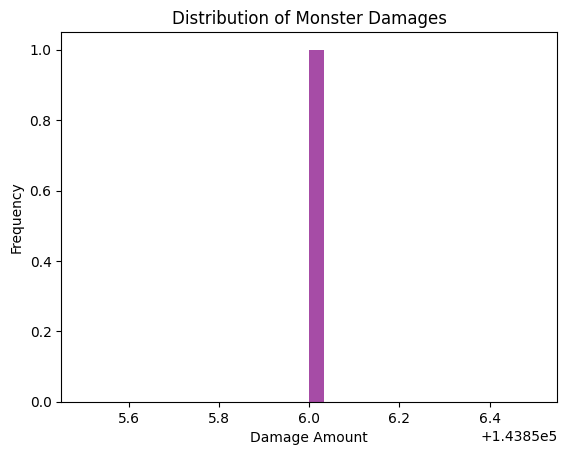

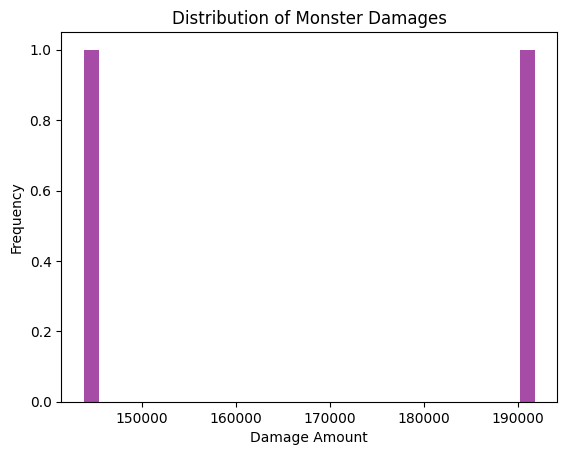

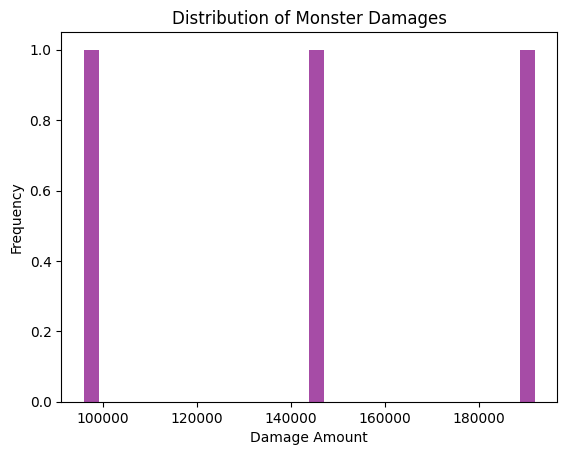

KeyboardInterrupt: 

In [14]:
from confluent_kafka import Consumer, KafkaError
from datetime import datetime, timedelta
import json 
import random
import pandas as pd
import matplotlib.pyplot as plt

conf = {
    'bootstrap.servers': 'b-1.monstercluster1.6xql65.c3.kafka.eu-west-2.amazonaws.com:9092',  
    'group.id': 'your_group_id',
    'auto.offset.reset': 'earliest',
}

consumer = Consumer(conf)

def consume_message():
    consumer.subscribe(['monster-damage'])
    while True:
        msg = consumer.poll(1.0)
        if msg is None:
            continue
        if msg.error():
            if msg.error().code() == KafkaError._PARTITION_EOF:
                continue
            else:
                print(msg.error())
                break
        else:
            yield msg.value().decode('utf-8')

try:
    sample_rate = 0.1  # 10%
    sampled_data = []
    for message in consume_message():
        data = json.loads(message)
        if random.random() < sample_rate:
            sampled_data.append(data)
            df = pd.DataFrame(sampled_data)
            plt.hist(df['damage'], bins=30, color='purple', alpha=0.7)
            plt.title("Distribution of Monster Damages")
            plt.xlabel("Damage Amount")
            plt.ylabel("Frequency")
            plt.show()

finally:
    consumer.close()

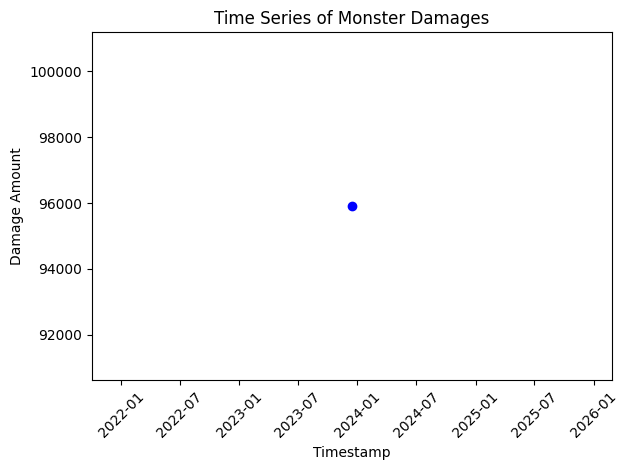

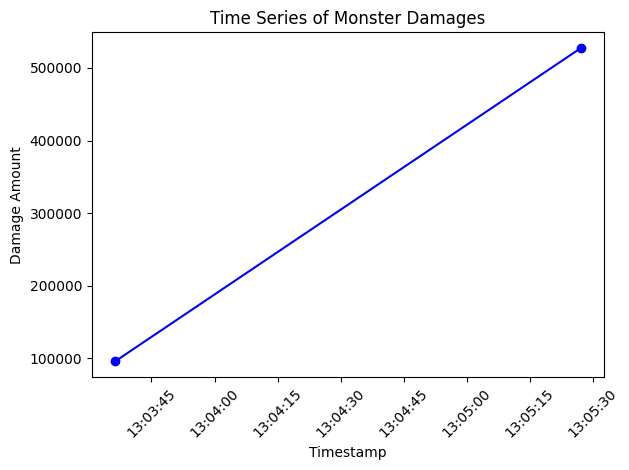

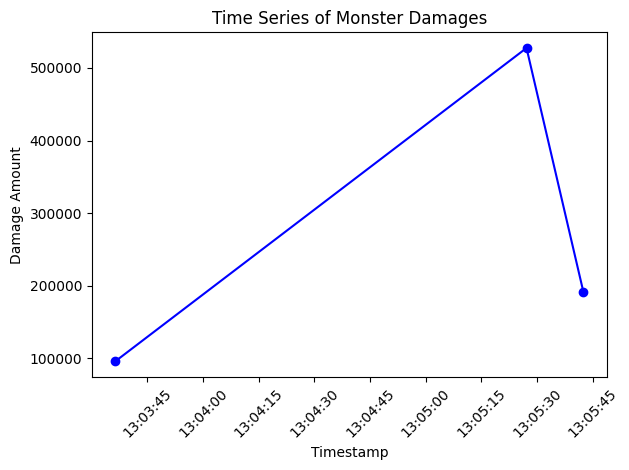

KeyboardInterrupt: 

In [15]:
from confluent_kafka import Consumer, KafkaError
from datetime import datetime, timedelta
import json 
import random
import pandas as pd
import matplotlib.pyplot as plt

conf = {
    'bootstrap.servers': 'b-1.monstercluster1.6xql65.c3.kafka.eu-west-2.amazonaws.com:9092',  
    'group.id': 'your_group_id',
    'auto.offset.reset': 'earliest',
}

consumer = Consumer(conf)

def consume_message():
    consumer.subscribe(['monster-damage'])
    while True:
        msg = consumer.poll(1.0)
        if msg is None:
            continue
        if msg.error():
            if msg.error().code() == KafkaError._PARTITION_EOF:
                continue
            else:
                print(msg.error())
                break
        else:
            yield msg.value().decode('utf-8')

try:
    sample_rate = 0.1  # 10%
    sampled_data = []
    for message in consume_message():
        data = json.loads(message)
        if random.random() < sample_rate:
            sampled_data.append(data)
            df = pd.DataFrame(sampled_data)
            df['ts'] = pd.to_datetime(df['ts'])
            plt.plot(df['ts'], df['damage'], marker='o', linestyle='-', color='blue')
            plt.title("Time Series of Monster Damages")
            plt.xlabel("Timestamp")
            plt.ylabel("Damage Amount")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

finally:
    consumer.close()